In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, sampler, TensorDataset
from torch.utils.data import sampler

import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

import math
import numpy as np
from PIL import Image

from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage.filters import gaussian_filter

from pathlib import Path

from time import time

import models as models

from torch.autograd import Variable
from tqdm import tqdm

import os

# import warnings
# warnings.filterwarnings('ignore')

/var/folders/hg/by60chbx3gv__xtd5c1p9sxm0000gn/T/ipykernel_65645/2146603971.py:21: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
USE_GPU = False

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cpu


In [3]:
train_directory = '/Volumes/DataDrive/clim_tif/train'
test_directory = '/Volumes/DataDrive/clim_tif/test'
val_directory = '/Volumes/DataDrive/clim_tif/val'

##########################################################################################
#                                  BATCH_SIZE PARAMETER
BATCH_SIZE = 1
##########################################################################################


sr_train = models.SR_Dataset(train_directory)
loader_train = DataLoader(sr_train, batch_size=BATCH_SIZE)


sr_val = models.SR_Dataset(val_directory)
loader_val = DataLoader(sr_val, batch_size=BATCH_SIZE)

sr_test = models.SR_Dataset(test_directory)
loader_test = DataLoader(sr_test, batch_size=BATCH_SIZE)

In [4]:
# Check to make sure the range on the input and output images is correct, and they're the correct shape
testx, testy = sr_train.__getitem__(3)
print("x shape: ", testx.shape)
print("y shape: ", testy.shape)
print("x min: ", torch.min(testx))
print("x max: ", torch.max(testx))
print("y min: ", torch.min(testy))
print("y max: ",torch.max(testy))

for x, y in loader_train:
    print(x.shape)
    break

x shape:  torch.Size([1, 64, 64])
y shape:  torch.Size([1, 64, 64])
x min:  tensor(232.9816)
x max:  tensor(301.7243)
y min:  tensor(231.2948)
y max:  tensor(303.2948)
torch.Size([1, 1, 64, 64])


In [5]:
dmodel = models.Discriminator()

In [7]:
out_img = dmodel(testy)

In [8]:
out_img.shape

torch.Size([1, 1])

In [9]:
rmodel = models.ResidualBlock(1)

In [10]:
out_img = rmodel(testx)

In [11]:
out_img.shape

torch.Size([64, 64, 64])

In [12]:
umodel = models.UpscaleBlock()

In [13]:
uout_img = umodel(out_img)

In [14]:
uout_img.shape

torch.Size([64, 128, 128])

In [15]:
gmodel = models.Generator(1)

In [16]:
gout_img = gmodel(testx.unsqueeze(0))

In [17]:
gout_img.shape

torch.Size([1, 1, 64, 64])

In [18]:
UPSCALE_FACTOR = 2
NUM_EPOCHS = 1

In [19]:
def test_Generator():
    h = 32
    w = h
#     x = torch.zeros((1, NUM_CHANNELS_IN, h, w), dtype=dtype) 
    x = (sr_train.__getitem__(5)[0])
    print(x.shape)
    
    model = models.Generator(1, scale_factor=2)
    model = model.to(device=device)
    x = x.to(device=device, dtype=dtype)
    output = model(x)
    
    print(output.shape)
    
    print(np.amin(output[0,:,:].detach().numpy()))
    print(np.amax(output[0,:,:].detach().numpy()))
    print(np.mean(output[0,:,:].detach().numpy()))
    plt.subplot(121)
    plt.imshow(x.cpu().detach().numpy()[0,:, :])
    plt.title("Input Precip")
    plt.subplot(122)
    plt.imshow(output.cpu().detach().numpy()[0,:, :])
    plt.title("Output Precip")
    plt.figure()
    plt.subplot(121)
    plt.imshow(x.cpu().detach().numpy()[0,:, :])
    plt.title("Input Temperature")
    plt.subplot(122)
    plt.imshow(output.cpu().detach().numpy()[0,:, :])
    plt.title("Output Temperature")
    plt.show()

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
-1.0
-0.9999999
-1.0


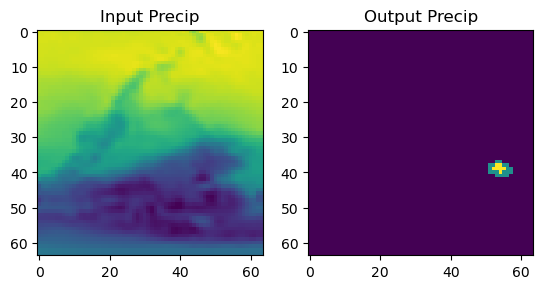

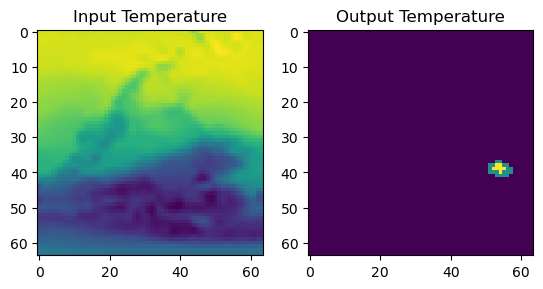

In [27]:
test_Generator()

In [28]:
netG = models.Generator(1,UPSCALE_FACTOR)
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))
netD = models.Discriminator()
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

mseLoss = nn.MSELoss()

# generator parameters: 232005
# discriminator parameters: 5210561


In [ ]:
torch.autograd.set_detect_anomaly(True)

results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

for epoch in range(1, NUM_EPOCHS + 1):
    train_bar = tqdm(loader_train)
    running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

    netG.train()
    netD.train()
    for data, target in train_bar:
        g_update_first = True
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        ##################################  
        # (1) Update D nework 
        # we want real_out to be close 1, and fake_out to be close 0 
        # maximize D(x) - D(G(z)) + [1] x: real_out D(G(z)): fake_out 
        ##################################
        real_img = Variable(target)
        #print(f"Real Image Shape: {real_img.shape}")
        z = Variable(data)
        #print(f"z Variable Shape: {z.shape}")
        fake_img = netG(z)
        #print(f"Fake Image Shape: {fake_img.shape}")

        netD.zero_grad()
        real_out = netD(real_img).mean()
        fake_out = netD(fake_img).mean()
        d_loss = 1 - real_out + fake_out
        d_loss.backward(retain_graph=True)


        ###################################
        # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
        ###################################
        netG.zero_grad()
        g_loss = mseLoss(fake_out, real_img)
        g_loss.backward()

        optimizerD.step()
        optimizerG.step()

        # loss for current batch before optimization 
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size

        train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
            epoch, NUM_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'], 
            running_results['g_loss'] / running_results['batch_sizes'], 
            running_results['d_score'] / running_results['batch_sizes'], 
            running_results['g_score'] / running_results['batch_sizes']
        ))

    netG.eval()
    

In [ ]:
base_folder = 'Volumes/DataDrive/clim_model_runs'
run_number = 1

In [ ]:
sub_path = 'training_results/SRF_' + str(run_number) + '/'
out_path = os.path.joint(base_folder, sub_path)
print(out_path)

if not os.path.exists(out_path):
    os.makedirs(out_path)

with torch.no_grad():
    val_bar = tqdm(loader_val)
    valing_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
    val_images = []
    for val_lr, val_hr_restore, val_hr in val_bar:
        batch_size = val_lr.size(0)
        valing_results['batch_sizes'] += batch_size
        lr = val_lr
        hr = val_hr
        if torch.cuda.is_available():
            lr = lr.cuda()
            hr = hr.cuda()
        sr = netG(lr)

        batch_mse = ((sr - hr) ** 2).data.mean()
        valing_results['mse'] += batch_mse * batch_size
        batch_ssim = pytorch_ssim.ssim(sr, hr).item()
        valing_results['ssims'] += batch_ssim * batch_size
        valing_results['psnr'] = 10 * np.log10((hr.max()**2) / (valing_results['mse'] / valing_results['batch_sizes']))
        valing_results['ssim'] = valing_results['ssims'] / valing_results['batch_sizes']
        val_bar.set_description(
            desc='[converting LR images to SR images] PSNR: %.4f dB SSIM: %.4f' % (
                valing_results['psnr'], valing_results['ssim']
            )
        )

        val_images.extend(
            [display_transform()(val_hr_restore.squeeze(0)), display_transform()(hr.data.cpu().squeeze(0)), 
                display_transform()(sr.data.cpu().squeeze(0))]
        )
    val_images = torch.stack(val_images)
    val_images = torch.chunk(val_images, val_images.size(0) // 15)
    val_save_bar = tqdm(val_images, desc='[saving training results]')
    index = 1
    for image in val_save_bar:
        image = utils.make_grid(image, nrow=3, padding=5)
        utils.save_image(image, out_path + 'epoch_%d_index_%d.png' % (epoch, index), padding=5)
        index += 1

# save model parameters
torch.save(netG.state_dict(), 'epochs/netG_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))
torch.save(netD.state_dict(), 'epochs/netD_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))
# save loss\scores\psnr\ssim
results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
results['psnr'].append(valing_results['psnr'])
results['ssim'].append(valing_results['ssim'])

if epoch % 10 == 0 and epoch != 0:
    out_path = "statistics/"
    data_frame = pd.DataFrame(
        data = {'Loss_D': results['d_loss'], 'Loss_G': results['g_loss'], 'Score_D': results['d_score'], 
                'Score_G': results['g_score'], 'PSNR': results['psnr'], 'SSIM': results['ssim'], }, 
                index=range(1, epoch+1)
    )
    data_frame.to_csv(out_path + 'srf_' + str(UPSCALE_FACTOR) + '_train_results.csv', index_label='Epoch')